# FM inference through Amazon Bedrock
In this notebook we will try out several FMs available through Amazon Bedrock. We will use **Amazon Bedrock in a cross-account way** i.e. we will assume an IAM role in a different account that does have Amazon Bedrock access enabled and use that role to run inferences (in other words we will be invoking the foundation models in the other account and all the costs for using Bedrock would be going into that account and not in this account).

<div style="background-color: #B0E0E6; padding: 10px; border-radius: 5px;">
<p style="margin: 0;">💡 <strong>Important Note:</strong> 
    
<ol style="margin: 10px 0 0 20px;">
   <li> Using Amazon Bedrock in a cross-account way from this notebook requires that you have a `BedrockCrossAccount.txt` file in your home directory, this would have been set through the LCC (Lifecycle configuration) script thyat runs automatically when you started this notebook. If the `BedrockCrossAccount.txt` is not present then you will get an error and will not be able to use Amazon Bedrock.</li>
   <li>The LCC also installs all relevant libraries such as `litellm`, `langchain`, `boto3` etc. in the `conda_python3` environment so that this notebook is ready to go without needing any more Python package installs</li>
</ol></p>
</div>

We will be using [`LiteLLM`](https://github.com/BerriAI/litellm) for interacting with Amazon Bedrock. LiteLLM provides a consistent interface for multiple model providers.

## Setup imports

In [1]:
import os
import time
import json
import boto3
import litellm
import logging
from pathlib import Path
from litellm import completion
from litellm import RateLimitError

## Setup logging

In [2]:
# Setup logging
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)


## Setup environment variables needed by `LiteLLM`

In [3]:
os.environ["AWS_REGION_NAME"] = "us-east-1"

## Assume cross-account role

<div style="background-color: #B0E0E6; padding: 10px; border-radius: 5px;">
<p style="margin: 0;">💡 <strong>Important Note:</strong>The credentials being retrieved here only last for about 60 minutes, so if you keep your notebook running for longer than that then you would need to run this cell again to refresh the credentials.</p>
</div>

In [4]:
ROLE_TO_ASSUME = Path(os.path.join(os.environ["HOME"],"BedrockCrossAccount.txt")).read_text().strip()
logger.info(f"ROLE_TO_ASSUME={ROLE_TO_ASSUME}")
  
# Use STS to assume role  
credentials = boto3.client('sts').assume_role(  
    RoleArn=ROLE_TO_ASSUME,  
    RoleSessionName='RoleBSession'  
)['Credentials']  
os.environ["AWS_ACCESS_KEY_ID"] = credentials['AccessKeyId']
os.environ["AWS_SECRET_ACCESS_KEY"] = credentials['SecretAccessKey']
os.environ["AWS_SESSION_TOKEN"] = credentials['SessionToken']

[2025-02-13 23:33:58,676] p1310 {4181295245.py:2} INFO - ROLE_TO_ASSUME=arn:aws:iam::605134468121:role/BedrockCrossAccount
[2025-02-13 23:33:58,721] p1310 {credentials.py:1075} INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


## A wrapper function to invoke LiteLLM
Keep the following code handy, we will be using this whenever we need to invoke Amazon Bedrock.

Set the `verbose` option to `True` just for now to see what goes on under the hood while invoking Amazon Bedrock from `LiteLLM`. This provides additional insights such as pricing information that are not available otherwise.

In [5]:
litellm.set_verbose=True

<div style="background-color: #B0E0E6; padding: 10px; border-radius: 5px;">
<p style="margin: 0;">💡 <strong>Important Note:</strong>The code below also has retry mechanism built-in to automatically retry the call after a wait time in case we get throttling errors from Amazon Bedrock (it is possible that you make too many calls in a short duration and some service quota limit gets hit, especially since we are all using the same Bedrock account, remember we are using Bedriock in a cross-account way)</p>
</div>

In [6]:
import litellm
from typing import Tuple
def get_inference(model_name: str, prompt: str, max_tokens: int = 100, temperature: float = 0.7, n: int = 1, top_p: float = 1, stream: bool = False) -> Tuple[litellm.types.utils.ModelResponse, float]:
    import sys
    import time
    max_retries = 10
    retry_delay = 60  # seconds
    
    for attempt in range(max_retries):
        try:
            # Your task processing code here
            print(f"model_name={model_name}")
            st = time.perf_counter()
            response = completion(
                    model=model_name,
                    model_id=None,
                    messages=[{"role": "user", "content": prompt}],
                    max_tokens=max_tokens,
                    temperature=temperature,
                    n=n,
                    top_p=top_p,
                    stream=stream
                )
            latency = time.perf_counter() - st
            print(f"got response in {latency:0.2f}s")
            return response, latency
        except RateLimitError as e:
            if attempt < max_retries - 1:
                this_retry_delay = retry_delay * (attempt + 1) + random.randint(1, 10)
                print(f"rate limit hit for model_id {model_id} on attempt {attempt + 1}. Waiting {this_retry_delay} seconds...", file=sys.stderr, flush=True)
                time.sleep(this_retry_delay)
                continue
            else:
                print(f"max retries exceeded for model_id {model_id}", file=sys.stderr, flush=True)
                raise  # Re-raise the exception if we've exhausted all retries
                
        except Exception as e:
            print(f"Unexpected error processing model_id {model_id}: {e}", file=sys.stderr, flush=True)
            raise

## Our first inference with Amazon Bedrock

We try this with a simple prompt. Try changing the prompt to generate different outputs.

In [7]:
prompt = "the little red riding hood"
model_id = "us.meta.llama3-1-8b-instruct-v1:0"
max_tokens = 100
temperature = 0.7
n = 1
top_p = 1
stream = False
response, latency = get_inference(model_id, prompt, max_tokens, temperature, n, top_p, stream)

23:34:07 - LiteLLM:WARNING: utils.py:460 - `litellm.set_verbose` is deprecated. Please set `os.environ['LITELLM_LOG'] = 'DEBUG'` for debug logs.
[2025-02-13 23:34:07,164] p1310 {utils.py:460} WARNING - `litellm.set_verbose` is deprecated. Please set `os.environ['LITELLM_LOG'] = 'DEBUG'` for debug logs.
23:34:07 - LiteLLM:INFO: utils.py:2944 - 
LiteLLM completion() model= us.meta.llama3-1-8b-instruct-v1:0; provider = bedrock
[2025-02-13 23:34:07,174] p1310 {utils.py:2944} INFO - 
LiteLLM completion() model= us.meta.llama3-1-8b-instruct-v1:0; provider = bedrock
[2025-02-13 23:34:07,189] p1310 {credentials.py:1147} INFO - Found credentials in environment variables.


model_name=us.meta.llama3-1-8b-instruct-v1:0
SYNC kwargs[caching]: False; litellm.cache: None; kwargs.get('cache')['no-cache']: False
Final returned optional params: {'temperature': 0.7, 'topP': 1, 'stream': False, 'maxTokens': 100, 'model_id': None}


[2025-02-13 23:34:08,686] p1310 {_client.py:1038} INFO - HTTP Request: POST https://bedrock-runtime.us-east-1.amazonaws.com/model/us.meta.llama3-1-8b-instruct-v1:0/converse "HTTP/1.1 200 OK"
23:34:08 - LiteLLM:INFO: utils.py:1120 - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:34:08,688] p1310 {utils.py:1120} INFO - Wrapper: Completed Call, calling success_handler


RAW RESPONSE:
{"metrics":{"latencyMs":1473},"output":{"message":{"content":[{"text":"\n\n\"The Little Red Riding Hood\" is a classic European fairy tale collected by the Brothers Grimm. The story revolves around a young girl named Little Red Riding Hood, who is tasked by her mother to take a basket of food to her sick grandmother who lives in a nearby village.\n\nAs Little Red Riding Hood walks through the forest, she encounters a sly and cunning wolf. The wolf tricks her by asking her where she is going and what she is carrying, and then runs ahead to grandmother's house to eat"}],"role":"assistant"}},"stopReason":"max_tokens","usage":{"inputTokens":19,"outputTokens":100,"totalTokens":119}}


got response in 1.53s


Examine all the fields of the output above. Lets parse out these fields by converting the output to a JSON structure.

In [8]:
logger.info(response.to_json())

[2025-02-13 23:34:26,076] p1310 {3777671960.py:1} INFO - {
  "id": "chatcmpl-fa856d8d-a8eb-41ee-a1fb-6e8a0a2a40f3",
  "created": 1739489648,
  "model": "us.meta.llama3-1-8b-instruct-v1:0",
  "object": "chat.completion",
  "system_fingerprint": null,
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "message": {
        "content": "\n\n\"The Little Red Riding Hood\" is a classic European fairy tale collected by the Brothers Grimm. The story revolves around a young girl named Little Red Riding Hood, who is tasked by her mother to take a basket of food to her sick grandmother who lives in a nearby village.\n\nAs Little Red Riding Hood walks through the forest, she encounters a sly and cunning wolf. The wolf tricks her by asking her where she is going and what she is carrying, and then runs ahead to grandmother's house to eat",
        "role": "assistant",
        "tool_calls": null,
        "function_call": null
      }
    }
  ],
  "usage": {
    "completion_t

In [9]:
logger.info(f"response: {response.choices[0].message.content}")

[2025-02-13 23:34:32,184] p1310 {3558623115.py:1} INFO - response: 

"The Little Red Riding Hood" is a classic European fairy tale collected by the Brothers Grimm. The story revolves around a young girl named Little Red Riding Hood, who is tasked by her mother to take a basket of food to her sick grandmother who lives in a nearby village.

As Little Red Riding Hood walks through the forest, she encounters a sly and cunning wolf. The wolf tricks her by asking her where she is going and what she is carrying, and then runs ahead to grandmother's house to eat


### Token counts
Pricing for most LLM providers such as Amazon Bedrock happens on the basis of token counts so it is very important to track them. We can do this by examining the `usage` field of the `LiteLLM` response.

In [10]:
logger.info(f"response: {response.usage}")

[2025-02-13 23:35:37,318] p1310 {4289907064.py:1} INFO - response: Usage(completion_tokens=100, prompt_tokens=19, total_tokens=119, completion_tokens_details=None, prompt_tokens_details=None)


### Streaming response
In a real-time application such as a customer service chatbot we need to start responding immediately rather than waiting for the entire response especially if the response is going to be long. We can do this by enabling streaming, this is simple, just set `stream=True`. We will generate a much longer response now by setting the `max_tokens=500` so that we can see the _response chunks_ being printed out.

**But first, set `verbose=False` otherwise we will get a lot of output which will clutter up the notebook**.

In [11]:
litellm.set_verbose=False

In [12]:
stream = True
max_tokens = 500
response, latency = get_inference(model_id, prompt, max_tokens, temperature, n, top_p, stream)
if stream is True:
    for part in response:
        print(part.choices[0].delta.content or "", end='', flush=True)

23:35:42 - LiteLLM:INFO: utils.py:2944 - 
LiteLLM completion() model= us.meta.llama3-1-8b-instruct-v1:0; provider = bedrock
[2025-02-13 23:35:42,710] p1310 {utils.py:2944} INFO - 
LiteLLM completion() model= us.meta.llama3-1-8b-instruct-v1:0; provider = bedrock


model_name=us.meta.llama3-1-8b-instruct-v1:0


[2025-02-13 23:35:43,104] p1310 {_client.py:1038} INFO - HTTP Request: POST https://bedrock-runtime.us-east-1.amazonaws.com/model/us.meta.llama3-1-8b-instruct-v1:0/converse-stream "HTTP/1.1 200 OK"


got response in 0.40s


"The Little Red Riding Hood" is a classic European folk tale collected by the Brothers Grimm. The story revolves around a young girl named Little Red Riding Hood, who is tasked by her mother to take a basket of food to her sick grandmother who lives in a nearby village.

As Little Red Riding Hood walks through the forest, she encounters a sly and cunning wolf. The wolf tricks her into giving him her basket and then runs ahead to Grandmother's house. When he arrives, he eats the grandmother and disguises himself as her.

Meanwhile, Little Red Riding Hood continues on her way, unaware of the wolf's plan. When she arrives at Grandmother's house, the wolf, dressed as Grandmother, greets her and asks her to come closer. Little Red Riding Hood notices that something is amiss, but the wolf convinces her to come closer.

Just as the wolf is about to pounce, a woodsman arrives and saves the day by cutting open the wolf's stomach with his axe. Little Red Riding Hood and h

## Task 1: try out different models available in Amazon Bedrock and analyze the output

1. Run the following prompt _"Pros and cons of Python Vs Golang as a first programming language for high school students"_ through model list provided below. 
1. Set **max_tokens to 100, stream=False, temperature=0.7, top_p=1, n=1**.
1. Print out the outputs as in the example code provided above. **Your notebook should show the output printed out in a readable fashion**.
1. Create a Pandas dataframe by combining the responses from all the models. The dataframe should contain the following fields: **model_id**, **response**, **latency**, **prompt_tokens**, **completion_tokens**.
1. Sort the dataframe in ascending order of the `latency` field.
1. Save the dataframe to a csv file called `problem1_task1.csv`. **Commit and push this file to repo**.



In [13]:
model_id_list = ["bedrock/us.meta.llama3-1-70b-instruct-v1:0",
                 "bedrock/us.meta.llama3-2-1b-instruct-v1:0",
                 "bedrock/us.meta.llama3-2-3b-instruct-v1:0",
                 "bedrock/us.meta.llama3-2-11b-instruct-v1:0",
                 "bedrock/us.meta.llama3-2-90b-instruct-v1:0",
                 "bedrock/us.anthropic.claude-3-5-sonnet-20241022-v2:0",
                 "bedrock/us.anthropic.claude-3-5-haiku-20241022-v1:0",
                 "bedrock/amazon.nova-lite-v1:0",
                 "bedrock/amazon.nova-micro-v1:0",
                 "bedrock/amazon.nova-pro-v1:0"]

In [14]:
prompt: str = "Pros and cons of Python Vs Golang as a first programming language for high school students"

In [15]:
max_tokens: int = 500
stream: bool = False
temperature: int = 0.7
top_p=1
n=1

In [16]:
response_list = []
for model_id in model_id_list:
    response, latency = get_inference(model_id, prompt, max_tokens, temperature, n, top_p, stream)
    response_dict = dict(model_id=model_id,
                         response=response.choices[0].message.content,
                         latency=latency,
                         prompt_tokens=response.usage.prompt_tokens,
                         completion_tokens=response.usage.completion_tokens)
    logger.info(f"model_id={model_id}\nresponse={response.choices[0].message.content}")
    response_list.append(response_dict)
    


23:36:13 - LiteLLM:INFO: utils.py:2944 - 
LiteLLM completion() model= us.meta.llama3-1-70b-instruct-v1:0; provider = bedrock
[2025-02-13 23:36:13,476] p1310 {utils.py:2944} INFO - 
LiteLLM completion() model= us.meta.llama3-1-70b-instruct-v1:0; provider = bedrock


model_name=bedrock/us.meta.llama3-1-70b-instruct-v1:0


[2025-02-13 23:36:29,892] p1310 {_client.py:1038} INFO - HTTP Request: POST https://bedrock-runtime.us-east-1.amazonaws.com/model/us.meta.llama3-1-70b-instruct-v1:0/converse "HTTP/1.1 200 OK"
23:36:29 - LiteLLM:INFO: utils.py:1120 - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:36:29,894] p1310 {utils.py:1120} INFO - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:36:29,902] p1310 {2326171432.py:9} INFO - model_id=bedrock/us.meta.llama3-1-70b-instruct-v1:0
response=

Choosing the first programming language for high school students can be a crucial decision, as it can affect their learning experience, motivation, and future career prospects. Here's a balanced comparison of Python and Go (also known as Golang) as a first programming language for high school students:

**Python:**

Pros:

1. **Easy to learn**: Python has a simple syntax, making it an excellent language for beginners. Its readability and concise code structure help students grasp programmi

got response in 16.43s
model_name=bedrock/us.meta.llama3-2-1b-instruct-v1:0


[2025-02-13 23:36:35,300] p1310 {_client.py:1038} INFO - HTTP Request: POST https://bedrock-runtime.us-east-1.amazonaws.com/model/us.meta.llama3-2-1b-instruct-v1:0/converse "HTTP/1.1 200 OK"
23:36:35 - LiteLLM:INFO: utils.py:1120 - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:36:35,302] p1310 {utils.py:1120} INFO - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:36:35,304] p1310 {2326171432.py:9} INFO - model_id=bedrock/us.meta.llama3-2-1b-instruct-v1:0
response=**Introduction**

As a high school student, choosing a programming language to learn can be a daunting task. Both Python and Go are popular languages, but they have different strengths and weaknesses. In this comparison, we'll highlight the pros and cons of each language, helping you decide which one is the best fit for your learning journey.

**Python**

**Pros:**

1. **Easy to learn**: Python has a simple syntax and is relatively easy to read and write, making it an excellent choice for begi

got response in 5.40s
model_name=bedrock/us.meta.llama3-2-3b-instruct-v1:0


[2025-02-13 23:36:42,602] p1310 {_client.py:1038} INFO - HTTP Request: POST https://bedrock-runtime.us-east-1.amazonaws.com/model/us.meta.llama3-2-3b-instruct-v1:0/converse "HTTP/1.1 200 OK"
23:36:42 - LiteLLM:INFO: utils.py:1120 - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:36:42,607] p1310 {utils.py:1120} INFO - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:36:42,612] p1310 {2326171432.py:9} INFO - model_id=bedrock/us.meta.llama3-2-3b-instruct-v1:0
response=**Introduction**

Choosing a programming language as a first language for high school students can be a crucial decision. Both Python and Golang have their unique strengths and weaknesses. Here's a comparison of the two languages, highlighting their pros and cons as a first language for high school students:

**Python**

Pros:

1. **Easy to learn**: Python has a simple syntax and is relatively easy to read and write, making it perfect for beginners.
2. **High-level language**: Python is a high

got response in 7.31s
model_name=bedrock/us.meta.llama3-2-11b-instruct-v1:0


[2025-02-13 23:36:46,609] p1310 {_client.py:1038} INFO - HTTP Request: POST https://bedrock-runtime.us-east-1.amazonaws.com/model/us.meta.llama3-2-11b-instruct-v1:0/converse "HTTP/1.1 200 OK"
23:36:46 - LiteLLM:INFO: utils.py:1120 - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:36:46,616] p1310 {utils.py:1120} INFO - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:36:46,621] p1310 {2326171432.py:9} INFO - model_id=bedrock/us.meta.llama3-2-11b-instruct-v1:0
response=**Introduction**

When it comes to teaching programming to high school students, the choice of language can significantly impact their learning experience and future career prospects. Python and Go (also known as Golang) are two popular programming languages that are often considered for beginners. Here, we'll discuss the pros and cons of each language as a first programming language for high school students.

**Python**

**Pros:**

1. **Easy to read and write**: Python's syntax is simple an

got response in 4.01s
model_name=bedrock/us.meta.llama3-2-90b-instruct-v1:0


[2025-02-13 23:37:00,748] p1310 {_client.py:1038} INFO - HTTP Request: POST https://bedrock-runtime.us-east-1.amazonaws.com/model/us.meta.llama3-2-90b-instruct-v1:0/converse "HTTP/1.1 200 OK"
23:37:00 - LiteLLM:INFO: utils.py:1120 - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:37:00,751] p1310 {utils.py:1120} INFO - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:37:00,754] p1310 {2326171432.py:9} INFO - model_id=bedrock/us.meta.llama3-2-90b-instruct-v1:0
response=**Python vs Golang as a First Programming Language for High School Students**

When it comes to choosing a first programming language for high school students, Python and Golang (also known as Go) are two popular options. Here are some pros and cons of each language to help you decide:

**Python**
-----------

### Pros:

1. **Easy to learn**: Python has a simple syntax and is often taught in introductory programming courses due to its readability and ease of use.
2. **Versatile**: Python can

got response in 14.13s
model_name=bedrock/us.anthropic.claude-3-5-sonnet-20241022-v2:0


[2025-02-13 23:37:15,773] p1310 {_client.py:1038} INFO - HTTP Request: POST https://bedrock-runtime.us-east-1.amazonaws.com/model/us.anthropic.claude-3-5-sonnet-20241022-v2:0/converse "HTTP/1.1 200 OK"
23:37:15 - LiteLLM:INFO: utils.py:1120 - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:37:15,775] p1310 {utils.py:1120} INFO - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:37:15,777] p1310 {2326171432.py:9} INFO - model_id=bedrock/us.anthropic.claude-3-5-sonnet-20241022-v2:0
response=Here's a comparison of Python and Golang as first programming languages for high school students:

Python Pros:
1. Easy to learn
- Simple, readable syntax
- Less boilerplate code
- Whitespace-based indentation enforces clean code
- English-like syntax is intuitive

2. Large community & resources
- Abundant learning materials
- Extensive libraries
- Many tutorials and examples
- Active Stack Overflow community

3. Versatility
- Suitable for web, data science, AI/ML
- Can b

got response in 15.02s
model_name=bedrock/us.anthropic.claude-3-5-haiku-20241022-v1:0


[2025-02-13 23:37:24,027] p1310 {_client.py:1038} INFO - HTTP Request: POST https://bedrock-runtime.us-east-1.amazonaws.com/model/us.anthropic.claude-3-5-haiku-20241022-v1:0/converse "HTTP/1.1 200 OK"
23:37:24 - LiteLLM:INFO: utils.py:1120 - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:37:24,029] p1310 {utils.py:1120} INFO - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:37:24,032] p1310 {2326171432.py:9} INFO - model_id=bedrock/us.anthropic.claude-3-5-haiku-20241022-v1:0
response=Here's a comparison of Python and Golang for high school students:

Python Pros:
1. Easier learning curve
2. More beginner-friendly syntax
3. Extensive libraries and resources
4. Wide application domains (web, data science, AI, scripting)
5. Large community support
6. Faster development speed
7. More forgiving for beginners
8. Interpreted language
9. Excellent documentation
10. Used in many academic and industry settings

Python Cons:
1. Slower performance
2. Global Interpr

got response in 8.25s
model_name=bedrock/amazon.nova-lite-v1:0


[2025-02-13 23:37:28,513] p1310 {_client.py:1038} INFO - HTTP Request: POST https://bedrock-runtime.us-east-1.amazonaws.com/model/amazon.nova-lite-v1:0/converse "HTTP/1.1 200 OK"
23:37:28 - LiteLLM:INFO: utils.py:1120 - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:37:28,515] p1310 {utils.py:1120} INFO - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:37:28,517] p1310 {2326171432.py:9} INFO - model_id=bedrock/amazon.nova-lite-v1:0
response=Choosing a first programming language for high school students is a significant decision that can influence their future interests and abilities in the field of computer science. Here are the pros and cons of using Python and Golang as introductory programming languages:

### Python

#### Pros:
1. **Ease of Learning**:
   - Python's syntax is very readable and similar to plain English, making it easier for beginners to understand.
   - It has a simple and concise structure, which helps students focus on understanding

got response in 4.48s
model_name=bedrock/amazon.nova-micro-v1:0


[2025-02-13 23:37:31,622] p1310 {_client.py:1038} INFO - HTTP Request: POST https://bedrock-runtime.us-east-1.amazonaws.com/model/amazon.nova-micro-v1:0/converse "HTTP/1.1 200 OK"
23:37:31 - LiteLLM:INFO: utils.py:1120 - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:37:31,624] p1310 {utils.py:1120} INFO - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:37:31,626] p1310 {2326171432.py:9} INFO - model_id=bedrock/amazon.nova-micro-v1:0
response=Choosing a first programming language for high school students is a significant decision that can shape their enthusiasm for coding and set the foundation for future learning. Here are the pros and cons of Python versus Golang as a first choice:

### Python

**Pros:**

1. **Ease of Learning**: Python is known for its simple and readable syntax, which makes it an excellent choice for beginners. The straightforward code can help students grasp basic programming concepts without getting bogged down by complex syntax.


got response in 3.11s
model_name=bedrock/amazon.nova-pro-v1:0


[2025-02-13 23:37:38,130] p1310 {_client.py:1038} INFO - HTTP Request: POST https://bedrock-runtime.us-east-1.amazonaws.com/model/amazon.nova-pro-v1:0/converse "HTTP/1.1 200 OK"
23:37:38 - LiteLLM:INFO: utils.py:1120 - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:37:38,132] p1310 {utils.py:1120} INFO - Wrapper: Completed Call, calling success_handler
[2025-02-13 23:37:38,134] p1310 {2326171432.py:9} INFO - model_id=bedrock/amazon.nova-pro-v1:0
response=Choosing a first programming language for high school students involves considering factors such as ease of learning, community support, versatility, and the type of projects they might want to undertake. Here’s a comparison of Python and Golang in this context:

### Python

#### Pros:
1. **Ease of Learning**:
   - Python has a simple and readable syntax, making it easy for beginners to understand and write code.
   - The language emphasizes readability and reduces the cost of program maintenance.

2. **Versatility**:


got response in 6.51s


In [17]:
import pandas as pd
df = pd.DataFrame(response_list)
df = df.sort_values(by='latency')

[2025-02-13 23:37:38,270] p1310 {utils.py:162} INFO - NumExpr defaulting to 4 threads.


In [18]:
display(df)

,model_id,response,latency,prompt_tokens,completion_tokens
8,bedrock/amazon.nova-micro-v1:0,Choosing a first programming language for high...,3.106886,18,500
3,bedrock/us.meta.llama3-2-11b-instruct-v1:0,**Introduction**\n\nWhen it comes to teaching ...,4.006783,52,500
7,bedrock/amazon.nova-lite-v1:0,Choosing a first programming language for high...,4.483899,18,500
1,bedrock/us.meta.llama3-2-1b-instruct-v1:0,"**Introduction**\n\nAs a high school student, ...",5.400780,52,500
9,bedrock/amazon.nova-pro-v1:0,Choosing a first programming language for high...,6.505722,18,500
2,bedrock/us.meta.llama3-2-3b-instruct-v1:0,**Introduction**\n\nChoosing a programming lan...,7.305999,52,500
6,bedrock/us.anthropic.claude-3-5-haiku-20241022...,Here's a comparison of Python and Golang for h...,8.251509,26,331
4,bedrock/us.meta.llama3-2-90b-instruct-v1:0,**Python vs Golang as a First Programming Lang...,14.131035,52,500
5,bedrock/us.anthropic.claude-3-5-sonnet-2024102...,Here's a comparison of Python and Golang as fi...,15.021307,26,500
0,bedrock/us.meta.llama3-1-70b-instruct-v1:0,\n\nChoosing the first programming language fo...,16.427210,31,500


In [19]:
df.to_csv("problem1_task1.csv")

## Task 2 - Vibe check the model outputs
Examine the output generated by all models and write a very short summary (5 to 10 lines) about how you compare the outputs across model families i.e. how does the output generated by the Llama family of models compare with the Claude family of models comparte with the Nova family of models. You don't have to over think this, think of this like a [vibe check](https://www.linkedin.com/pulse/vibecheck-discover-quantify-qualitative-differences-large-bogolin-c4awe/). Write your thoughts in a file called `problem1_task2.txt`. **Commit and push this file to repo**.


## Task 3 - Create a chart comparing latency across models

As you would have seen that different models we tried abovew have very different latencies. The latency and the quality of the output (along with the dollar cost of course) is critical in deciding which model to use for which task.

1. Create a bar chart for visualizing model latencies.
1. Color code the bar chart by model families i.e. the bars for the Claude models are in one color, LLama models in another color and so on and so forth.
1. Save the plot in a file called `problem1_task3.png`. **Commit and push this file to repo**.
1. Write a couple of lines of description in the notebook itself as to what is your interpretation from this chart that you created.

[2025-02-13 23:37:44,930] p1310 {font_manager.py:1639} INFO - generated new fontManager


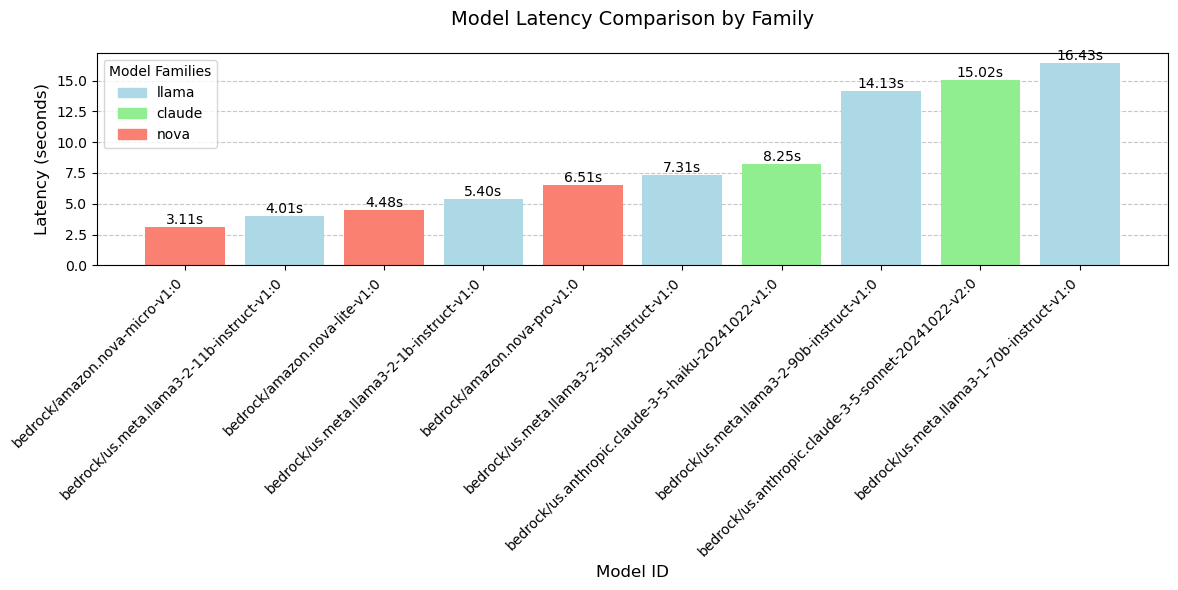

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Define color mapping for model families
color_map = {
   'llama': 'lightblue',
   'claude': 'lightgreen',
   'nova': 'salmon'
}

# Function to determine model family from model_id
def get_model_family(model_id):
   model_id = model_id.lower()
   if 'llama' in model_id:
       return 'llama'
   elif 'claude' in model_id:
       return 'claude'
   elif 'nova' in model_id:
       return 'nova'
   return 'other'

# Create bars with colors based on model family
bars = []
for i, (model_id, latency) in enumerate(zip(df['model_id'], df['latency'])):
   family = get_model_family(model_id)
   bar = ax.bar(model_id, latency, color=color_map.get(family, 'gray'))
   bars.extend(bar)

# Customize the chart
ax.set_title('Model Latency Comparison by Family', fontsize=14, pad=20)
ax.set_xlabel('Model ID', fontsize=12)
ax.set_ylabel('Latency (seconds)', fontsize=12)

# Add grid
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
   height = bar.get_height()
   ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.2f}s',
           ha='center', va='bottom')

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, color=color) 
                 for color in color_map.values()]
ax.legend(legend_elements, color_map.keys(), title="Model Families")

# Adjust layout
plt.tight_layout()
plt.savefig("problem1_task3.png")
plt.show()

#### Observations from the latency visualization
(write your thoughts here)

## GraphRAG

In [21]:
import nest_asyncio
import asyncio
from nano_graphrag import GraphRAG, QueryParam

In [28]:
!curl https://raw.githubusercontent.com/gusye1234/nano-graphrag/main/tests/mock_data.txt > book.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  184k  100  184k    0     0  1712k      0 --:--:-- --:--:-- --:--:-- 1727k


In [22]:
# Apply nest_asyncio to allow nested event loops in SageMaker
nest_asyncio.apply()

In [23]:
# Select a model from the provided list
best_model_id = "bedrock/us.anthropic.claude-3-5-sonnet-20241022-v2:0"
cheap_model_id = "bedrock/us.anthropic.claude-3-5-haiku-20241022-v1:0"

In [24]:
# Initialize GraphRAG with Amazon Bedrock
graph_func = GraphRAG(
    working_dir="./dickens",
    using_amazon_bedrock=True,
    best_model_id=best_model_id,
    cheap_model_id=cheap_model_id,
)

[2025-02-13 23:38:33,460] p1310 {graphrag.py:157} INFO - Switched the default openai funcs to Amazon Bedrock
[2025-02-13 23:38:33,463] p1310 {graphrag.py:162} INFO - Creating working directory ./dickens
[2025-02-13 23:38:33,471] p1310 {kv_json.py:16} INFO - Load KV full_docs with 0 data
[2025-02-13 23:38:33,476] p1310 {kv_json.py:16} INFO - Load KV text_chunks with 0 data
[2025-02-13 23:38:33,478] p1310 {kv_json.py:16} INFO - Load KV llm_response_cache with 0 data
[2025-02-13 23:38:33,481] p1310 {kv_json.py:16} INFO - Load KV community_reports with 0 data
[2025-02-13 23:38:33,483] p1310 {dbs.py:81} INFO - Init {'embedding_dim': 1024, 'metric': 'cosine', 'storage_file': './dickens/vdb_entities.json'} 0 data


In [29]:
# Load text from book.txt
with open("./book.txt") as f:
    data = f.read()

# Check if the file is empty
if not data.strip():
    raise ValueError("Error: book.txt is empty! Make sure it contains text.")

In [30]:
# Ensure text processing works properly
async def insert_and_query():
    # Insert text into GraphRAG
    await graph_func.ainsert(data)

    # Run global GraphRAG search
    prompt = "What are the top themes in this story?"
    global_result = await graph_func.aquery(prompt, param=QueryParam(mode="global"))
    print("\n🌍 Global GraphRAG Search Result:\n", global_result)

    # Run local GraphRAG search (preferred for scalability)
    local_result = await graph_func.aquery(prompt, param=QueryParam(mode="local"))
    print("\n🏠 Local GraphRAG Search Result:\n", local_result)

# Run the async function properly
await insert_and_query()

[2025-02-13 23:40:40,817] p1310 {graphrag.py:279} INFO - [New Docs] inserting 1 docs
[2025-02-13 23:40:41,404] p1310 {graphrag.py:299} INFO - [New Chunks] inserting 42 chunks
[2025-02-13 23:40:41,405] p1310 {graphrag.py:308} INFO - [Entity Extraction]...
[2025-02-13 23:40:41,422] p1310 {credentials.py:567} INFO - Found credentials in environment variables.
[2025-02-13 23:40:41,761] p1310 {gdb_networkx.py:28} INFO - Writing graph with 0 nodes, 0 edges


ValidationException: An error occurred (ValidationException) when calling the Converse operation: Your account is not authorized to invoke this API operation.

In [33]:
import boto3
import json

client = boto3.client("bedrock-runtime")

def get_bedrock_response(model_id, prompt, max_tokens=100):
    response = client.invoke_model(
        modelId=model_id,
        body=json.dumps({
            "prompt": prompt,
            "max_tokens": max_tokens
        }).encode("utf-8")  # Convert to JSON and encode as bytes
    )
    response_body = json.loads(response['body'].read().decode('utf-8'))
    return response_body

# Test with GraphRAG
model_id = "bedrock/us.meta.llama3-1-70b-instruct-v1:0"  # Adjust as needed
prompt = "Extract key themes from this text: AI and data science are transforming the world."

print(get_bedrock_response(model_id, prompt))

ValidationException: An error occurred (ValidationException) when calling the InvokeModel operation: Your account is not authorized to invoke this API operation.

In [35]:
async def amazon_bedrock_complete(model, prompt, max_tokens=500, temperature=0.7, top_p=1):
    """
    Queries Amazon Bedrock with the specified model and parameters.
    """
    request_payload = {
        "prompt": prompt,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "top_p": top_p
    }

    # Make the API call
    response = client.invoke_model(
        modelId=model,
        body=json.dumps(request_payload).encode("utf-8")
    )

    # Read and decode response
    response_body = json.loads(response['body'].read().decode('utf-8'))
    return response_body.get("output", {}).get("message", {}).get("content", "")

In [36]:
class GraphRAG:
    def __init__(self):
        self.chunk_entity_relation_graph = {}  # Placeholder for KG updates
        self.entities_vdb = {}  # Virtual database for entity storage

    async def ainsert(self, inserting_chunks):
        """
        Inserts new data into the knowledge graph.
        """
        logger.info("[Entity Extraction] Extracting entities...")
        
        # Extract entities using Bedrock
        maybe_new_kg = await self.extract_entities(inserting_chunks)

        if not maybe_new_kg:
            logger.warning("No new entities found")
            return

        # Update the knowledge graph
        self.chunk_entity_relation_graph.update(maybe_new_kg)
        logger.info(f"Updated Graph with {len(maybe_new_kg)} new entities.")

    async def extract_entities(self, chunks):
        """
        Extracts entities from given text chunks using LLM.
        """
        maybe_nodes = defaultdict(list)
        maybe_edges = defaultdict(list)

        async def process_single_content(chunk):
            content = chunk["content"]
            prompt = f"Extract key entities from the following text:\n\n{content}"

            # Query Bedrock
            result = await amazon_bedrock_complete(
                model="bedrock/us.meta.llama3-1-70b-instruct-v1:0",
                prompt=prompt
            )

            return result

        # Run entity extraction in parallel
        results = await asyncio.gather(*[process_single_content(c) for c in chunks])

        for result in results:
            # Parse result if it's structured as JSON
            try:
                extracted_data = json.loads(result)
                maybe_nodes.update(extracted_data.get("nodes", {}))
                maybe_edges.update(extracted_data.get("edges", {}))
            except json.JSONDecodeError:
                logger.warning(f"Could not parse entity extraction result: {result}")

        return dict(maybe_nodes), dict(maybe_edges)

    async def query(self, question):
        """
        Queries the knowledge graph.
        """
        prompt = f"Based on the following knowledge graph, answer: {question}"
        response = await amazon_bedrock_complete(
            model="bedrock/us.meta.llama3-1-70b-instruct-v1:0",
            prompt=prompt
        )
        return response

In [38]:
from collections import defaultdict

async def insert_and_query():
    """
    Inserts data into GraphRAG and queries it.
    """
    graph_func = GraphRAG()

    # Example input text
    data = [{"content": "AI and data science are transforming the world."}]

    # Insert text into GraphRAG
    await graph_func.ainsert(data)

    # Run a query
    question = "What are the key themes in this story?"
    result = await graph_func.query(question)

    print("\n🏠 Local GraphRAG Search Result:\n", result)

# Run the async function properly
asyncio.run(insert_and_query())

[2025-02-13 23:50:17,063] p1310 {2917536302.py:10} INFO - [Entity Extraction] Extracting entities...


ValidationException: An error occurred (ValidationException) when calling the InvokeModel operation: Your account is not authorized to invoke this API operation.

In [39]:
import boto3
import asyncio
import json
import logging
from collections import defaultdict

# Initialize Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ✅ Initialize AWS Bedrock Client Externally
bedrock_client = boto3.client("bedrock-runtime")

class NanoGraph:
    def __init__(self, bedrock_client):
        """
        Initialize NanoGraph with an externally provided Bedrock client.
        """
        self.bedrock_client = bedrock_client
        self.chunk_entity_relation_graph = defaultdict(list)
        self.entities_vdb = defaultdict(list)

    async def ainsert(self, inserting_chunks):
        """
        Inserts new data into the knowledge graph.
        """
        logger.info("[Entity Extraction] Extracting entities...")
        
        maybe_new_kg = await self.extract_entities(inserting_chunks)

        if not maybe_new_kg:
            logger.warning("No new entities found")
            return

        self.chunk_entity_relation_graph.update(maybe_new_kg)
        logger.info(f"✅ Updated Graph with {len(maybe_new_kg)} new entities.")

    async def extract_entities(self, chunks):
        """
        Extracts entities from given text chunks using Amazon Bedrock.
        """
        maybe_nodes = defaultdict(list)
        maybe_edges = defaultdict(list)

        async def process_single_content(chunk):
            content = chunk["content"]
            prompt = f"Extract key entities from the following text:\n\n{content}"

            # Query Bedrock using the externally provided client
            result = await self.query_bedrock(prompt)

            return result

        results = await asyncio.gather(*[process_single_content(c) for c in chunks])

        for result in results:
            try:
                extracted_data = json.loads(result)
                maybe_nodes.update(extracted_data.get("nodes", {}))
                maybe_edges.update(extracted_data.get("edges", {}))
            except json.JSONDecodeError:
                logger.warning(f"⚠️ Could not parse entity extraction result: {result}")

        return dict(maybe_nodes), dict(maybe_edges)

    async def query_bedrock(self, prompt, model="bedrock/us.meta.llama3-1-70b-instruct-v1:0", max_tokens=500, temperature=0.7, top_p=1):
        """
        Queries Amazon Bedrock with the specified parameters.
        """
        request_payload = {
            "prompt": prompt,
            "max_tokens": max_tokens,
            "temperature": temperature,
            "top_p": top_p
        }

        try:
            response = self.bedrock_client.invoke_model(
                modelId=model,
                body=json.dumps(request_payload).encode("utf-8")
            )
            response_body = json.loads(response['body'].read().decode('utf-8'))
            return response_body.get("output", {}).get("message", {}).get("content", "")
        except Exception as e:
            logger.error(f"❌ Bedrock API Error: {e}")
            return ""

    async def query(self, question):
        """
        Queries the knowledge graph.
        """
        prompt = f"Based on the following knowledge graph, answer: {question}"
        response = await self.query_bedrock(prompt)
        return response

In [40]:
async def insert_and_query():
    """
    Inserts data into NanoGraph and queries it.
    """
    graph_func = NanoGraph(bedrock_client)  # ✅ Injecting Bedrock client

    # Example input text
    data = [{"content": "AI and data science are transforming the world."}]

    # Insert text into NanoGraph
    await graph_func.ainsert(data)

    # Run a query
    question = "What are the key themes in this story?"
    result = await graph_func.query(question)

    print("\n🏠 NanoGraph Search Result:\n", result)

# Run the async function properly
asyncio.run(insert_and_query())

[2025-02-13 23:51:53,066] p1310 {4016533095.py:27} INFO - [Entity Extraction] Extracting entities...
[2025-02-13 23:51:53,129] p1310 {4016533095.py:85} ERROR - ❌ Bedrock API Error: An error occurred (ValidationException) when calling the InvokeModel operation: Your account is not authorized to invoke this API operation.
[2025-02-13 23:51:53,131] p1310 {4016533095.py:62} WARNING - ⚠️ Could not parse entity extraction result: 


ValueError: dictionary update sequence element #0 has length 0; 2 is required

In [41]:
import boto3
import asyncio
import json
import logging
from collections import defaultdict

# Initialize Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ✅ Initialize AWS Bedrock Client Externally
bedrock_client = boto3.client("bedrock-runtime")

class NanoGraph:
    def __init__(self, bedrock_client):
        """
        Initialize NanoGraph with an externally provided Bedrock client.
        """
        self.bedrock_client = bedrock_client
        self.chunk_entity_relation_graph = defaultdict(list)
        self.entities_vdb = defaultdict(list)

    async def ainsert(self, inserting_chunks):
        """
        Inserts new data into the knowledge graph.
        """
        logger.info("[Entity Extraction] Extracting entities...")
        
        maybe_new_kg = await self.extract_entities(inserting_chunks)

        if not maybe_new_kg:
            logger.warning("⚠️ No new entities found, skipping graph update.")
            return

        # ✅ Fix: Ensure dictionary update is valid
        for key, value in maybe_new_kg.items():
            self.chunk_entity_relation_graph[key].extend(value)

        logger.info(f"✅ Updated Graph with {len(maybe_new_kg)} new entities.")

    async def extract_entities(self, chunks):
        """
        Extracts entities from given text chunks using Amazon Bedrock.
        """
        maybe_nodes = defaultdict(list)
        maybe_edges = defaultdict(list)

        async def process_single_content(chunk):
            content = chunk["content"]
            prompt = f"Extract key entities from the following text:\n\n{content}"

            # Query Bedrock using the externally provided client
            result = await self.query_bedrock(prompt)

            return result

        results = await asyncio.gather(*[process_single_content(c) for c in chunks])

        for result in results:
            if not result:
                logger.warning("⚠️ Empty response from Bedrock API.")
                continue

            try:
                extracted_data = json.loads(result)
                maybe_nodes.update(extracted_data.get("nodes", {}))
                maybe_edges.update(extracted_data.get("edges", {}))
            except json.JSONDecodeError:
                logger.warning(f"⚠️ Could not parse entity extraction result: {result}")

        return dict(maybe_nodes), dict(maybe_edges)

    async def query_bedrock(self, prompt, model="bedrock/us.meta.llama3-1-70b-instruct-v1:0", max_tokens=500, temperature=0.7, top_p=1):
        """
        Queries Amazon Bedrock with the specified parameters.
        """
        request_payload = {
            "prompt": prompt,
            "max_tokens": max_tokens,
            "temperature": temperature,
            "top_p": top_p
        }

        try:
            response = self.bedrock_client.invoke_model(
                modelId=model,
                body=json.dumps(request_payload).encode("utf-8")
            )
            response_body = json.loads(response['body'].read().decode('utf-8'))
            return response_body.get("output", {}).get("message", {}).get("content", "")
        except Exception as e:
            logger.error(f"❌ Bedrock API Error: {e}")
            return ""

    async def query(self, question):
        """
        Queries the knowledge graph.
        """
        prompt = f"Based on the following knowledge graph, answer: {question}"
        response = await self.query_bedrock(prompt)
        return response

In [42]:
async def insert_and_query():
    """
    Inserts data into NanoGraph and queries it.
    """
    graph_func = NanoGraph(bedrock_client)  # ✅ Injecting Bedrock client

    # Example input text
    data = [{"content": "AI and data science are transforming the world."}]

    # Insert text into NanoGraph
    await graph_func.ainsert(data)

    # Run a query
    question = "What are the key themes in this story?"
    result = await graph_func.query(question)

    print("\n🏠 NanoGraph Search Result:\n", result)

# Run the async function properly
asyncio.run(insert_and_query())

[2025-02-13 23:53:37,255] p1310 {2068706249.py:27} INFO - [Entity Extraction] Extracting entities...
[2025-02-13 23:53:37,308] p1310 {2068706249.py:92} ERROR - ❌ Bedrock API Error: An error occurred (ValidationException) when calling the InvokeModel operation: Your account is not authorized to invoke this API operation.
[2025-02-13 23:53:37,310] p1310 {2068706249.py:61} WARNING - ⚠️ Empty response from Bedrock API.


AttributeError: 'tuple' object has no attribute 'items'

In [43]:
import boto3
import asyncio
import json
import logging
from collections import defaultdict

# Initialize Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ✅ Initialize AWS Bedrock Client
bedrock_client = boto3.client("bedrock-runtime")

class NanoGraph:
    def __init__(self, bedrock_client):
        """
        Initialize NanoGraph with an externally provided Bedrock client.
        """
        self.bedrock_client = bedrock_client
        self.chunk_entity_relation_graph = defaultdict(list)
        self.entities_vdb = defaultdict(list)

    async def ainsert(self, inserting_chunks):
        """
        Inserts new data into the knowledge graph.
        """
        logger.info("[Entity Extraction] Extracting entities...")
        
        # ✅ Unpacking tuple correctly
        maybe_nodes, maybe_edges = await self.extract_entities(inserting_chunks)

        if not maybe_nodes and not maybe_edges:
            logger.warning("⚠️ No new entities found, skipping graph update.")
            return

        # ✅ Updating the dictionaries separately
        for key, value in maybe_nodes.items():
            self.chunk_entity_relation_graph[key].extend(value)
        for key, value in maybe_edges.items():
            self.entities_vdb[key].extend(value)

        logger.info(f"✅ Updated Graph with {len(maybe_nodes)} new entities and {len(maybe_edges)} edges.")

    async def extract_entities(self, chunks):
        """
        Extracts entities from given text chunks using Amazon Bedrock.
        """
        maybe_nodes = defaultdict(list)
        maybe_edges = defaultdict(list)

        async def process_single_content(chunk):
            content = chunk["content"]
            prompt = f"Extract key entities from the following text:\n\n{content}"

            # Query Bedrock using the externally provided client
            result = await self.query_bedrock(prompt)
            return result

        results = await asyncio.gather(*[process_single_content(c) for c in chunks])

        for result in results:
            if not result:
                logger.warning("⚠️ Empty response from Bedrock API.")
                continue

            try:
                extracted_data = json.loads(result)
                for key, value in extracted_data.get("nodes", {}).items():
                    maybe_nodes[key].extend(value)
                for key, value in extracted_data.get("edges", {}).items():
                    maybe_edges[key].extend(value)
            except json.JSONDecodeError:
                logger.warning(f"⚠️ Could not parse entity extraction result: {result}")

        return dict(maybe_nodes), dict(maybe_edges)  # ✅ Returning a tuple (nodes, edges)

    async def query_bedrock(self, prompt, model="bedrock/us.meta.llama3-1-70b-instruct-v1:0", max_tokens=500, temperature=0.7, top_p=1):
        """
        Queries Amazon Bedrock with the specified parameters.
        """
        request_payload = {
            "prompt": prompt,
            "max_tokens": max_tokens,
            "temperature": temperature,
            "top_p": top_p
        }

        try:
            response = self.bedrock_client.invoke_model(
                modelId=model,
                body=json.dumps(request_payload).encode("utf-8")
            )
            response_body = json.loads(response['body'].read().decode('utf-8'))
            return response_body.get("output", {}).get("message", {}).get("content", "")
        except Exception as e:
            logger.error(f"❌ Bedrock API Error: {e}")
            return ""

    async def query(self, question):
        """
        Queries the knowledge graph.
        """
        prompt = f"Based on the following knowledge graph, answer: {question}"
        response = await self.query_bedrock(prompt)
        return response

In [44]:
async def insert_and_query():
    """
    Inserts data into NanoGraph and queries it.
    """
    graph_func = NanoGraph(bedrock_client)  # ✅ Injecting Bedrock client

    # Example input text
    data = [{"content": "AI and data science are transforming the world."}]

    # Insert text into NanoGraph
    await graph_func.ainsert(data)

    # Run a query
    question = "What are the key themes in this story?"
    result = await graph_func.query(question)

    print("\n🏠 NanoGraph Search Result:\n", result)

# Run the async function properly
asyncio.run(insert_and_query())

[2025-02-13 23:54:59,963] p1310 {3091410911.py:27} INFO - [Entity Extraction] Extracting entities...
[2025-02-13 23:55:00,048] p1310 {3091410911.py:96} ERROR - ❌ Bedrock API Error: An error occurred (ValidationException) when calling the InvokeModel operation: Your account is not authorized to invoke this API operation.
[2025-02-13 23:55:00,050] p1310 {3091410911.py:63} WARNING - ⚠️ Empty response from Bedrock API.
[2025-02-13 23:55:00,050] p1310 {3091410911.py:33} WARNING - ⚠️ No new entities found, skipping graph update.
[2025-02-13 23:55:00,084] p1310 {3091410911.py:96} ERROR - ❌ Bedrock API Error: An error occurred (ValidationException) when calling the InvokeModel operation: Your account is not authorized to invoke this API operation.



🏠 NanoGraph Search Result:
 


In [ ]:
GraphRAG(
    using_amazon_bedrock=True, 
    best_model_id="us.anthropic.claude-3-sonnet-20240229-v1:0",
    cheap_model_id="us.anthropic.claude-3-haiku-20240307-v1:0"
)